In [3]:
import pandas as pd

In [4]:
df_recs = pd.read_csv('../data/raw/recs_2020.csv')
print("RECS Shape:", df_recs.shape)
df_recs.head()

RECS Shape: (18496, 799)


,DOEID,REGIONC,DIVISION,STATE_FIPS,state_postal,state_name,BA_climate,IECC_climate_code,UATYP10,HDD65,...,EVCHRGHOME,EVCHRGAPT,EVCHRGWKS,EVCHRGBUS,EVCHRGMUNI,EVCHRGDLR,EVCHRGHWY,EVCHRGOTH,EVHOMEAMT,EVCHRGTYPE
0,100001,WEST,Mountain South,35,NM,New Mexico,Mixed-Dry,4B,U,3844,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1,100002,SOUTH,West South Central,5,AR,Arkansas,Mixed-Humid,4A,U,3766,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2,100003,WEST,Mountain South,35,NM,New Mexico,Mixed-Dry,4B,U,3819,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
3,100004,SOUTH,South Atlantic,45,SC,South Carolina,Mixed-Humid,3A,U,2614,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
4,100005,NORTHEAST,Middle Atlantic,34,NJ,New Jersey,Mixed-Humid,4A,U,4219,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


In [7]:
df_clean = df_recs[[
    'DOEID', 'REGIONC', 'DIVISION', 'state_postal', 'state_name',
    'YEARMADERANGE', 'FUELHEAT', 'TOTHSQFT'
]].copy()

df_clean = df_clean.rename(columns={
    'DOEID': 'home_id',
    'REGIONC': 'region',
    'DIVISION': 'division',
    'state_postal': 'state',
    'YEARMADERANGE': 'year_built_range',
    'FUELHEAT': 'heating_fuel_code',
    'TOTHSQFT': 'floor_area'
})
df_clean = df_clean.dropna(subset=['floor_area'])

df_clean = df_clean[df_clean['floor_area'] > 200] 
df_clean = df_clean[df_clean['floor_area'] < 10000]  # Drop massive outliers

# Final preview
print("Cleaned RECS shape:", df_clean.shape)
df_clean.head()

Cleaned RECS shape: (17705, 8)


,home_id,region,division,state,state_name,year_built_range,heating_fuel_code,floor_area
0,100001,WEST,Mountain South,NM,New Mexico,4,1,2100
1,100002,SOUTH,West South Central,AR,Arkansas,5,5,590
2,100003,WEST,Mountain South,NM,New Mexico,3,1,900
3,100004,SOUTH,South Atlantic,SC,South Carolina,5,1,2100
4,100005,NORTHEAST,Middle Atlantic,NJ,New Jersey,3,1,800


In [9]:
# Re-read the data
df_weather = pd.read_csv('../data/raw/noaa_temp_2020.csv', skiprows=4)
df_weather = df_weather.rename(columns={
    'Name': 'state_name',
    'Value': 'HDD'
})

# Standardize state name
df_weather['state_name'] = df_weather['state_name'].str.upper()

# Final preview
df_weather[['state_name', 'HDD']].head()


,state_name,HDD
0,ALABAMA,2284
1,ARIZONA,1834
2,ARKANSAS,3190
3,CALIFORNIA,2570
4,COLORADO,6814


In [11]:
# Convert both state fields to uppercase for matching
df_clean['state_name'] = df_clean['state_name'].str.upper()
df_weather['state_name'] = df_weather['state_name'].str.upper()

# Merge on 'state'
df_joined = df_clean.merge(df_weather[['state_name', 'HDD']], on='state_name', how='left')

# Preview
print("Joined shape:", df_joined.shape)
# Map heating fuel codes to readable labels
fuel_map = {
    1: 'Electricity',
    2: 'Natural Gas',
    3: 'Fuel Oil',
    4: 'Propane',
    5: 'Wood',
    6: 'Solar',
    7: 'Other',
    8: 'None'
}
df_joined['heating_fuel'] = df_joined['heating_fuel_code'].map(fuel_map)

# Map year built range to estimated year
year_map = {
    1: 1930,
    2: 1945,
    3: 1955,
    4: 1965,
    5: 1975,
    6: 1985,
    7: 1995,
    8: 2005,
    9: 2015,
    10: 2020
}
df_joined['year_built'] = df_joined['year_built_range'].map(year_map)
df_joined[['home_id', 'state_name', 'year_built', 'heating_fuel', 'floor_area', 'HDD']].head()

Joined shape: (17705, 9)


,home_id,state_name,year_built,heating_fuel,floor_area,HDD
0,100001,NEW MEXICO,1965,Electricity,2100,4166.0
1,100002,ARKANSAS,1975,Wood,590,3190.0
2,100003,NEW MEXICO,1955,Electricity,900,4166.0
3,100004,SOUTH CAROLINA,1975,Electricity,2100,2164.0
4,100005,NEW JERSEY,1955,Electricity,800,4615.0


In [12]:
# Load the income dataset
df_income = pd.read_csv('../data/raw/income_demographics.csv')

# Convert state names to uppercase for consistency
df_income['state_name'] = df_income['state_name'].str.upper()

# Calculate estimated income per return
df_income['estimated_income'] = df_income['adjusted_gross_income'] / df_income['number_of_returns']

# Group by state and take the mean
df_income_state_avg = df_income.groupby('state_name', as_index=False)['estimated_income'].mean()

# Preview
df_income_state_avg.head()


,state_name,estimated_income
0,ALABAMA,54.636451
1,ALASKA,66.438398
2,ARIZONA,65.825017
3,ARKANSAS,49.727946
4,CALIFORNIA,99.811971


In [14]:
# Merge with df_joined (RECS + HDD)
df_final = df_joined.merge(df_income_state_avg, on='state_name', how='left')

print("Final shape:", df_final.shape)
df_final[['home_id', 'state_name', 'year_built', 'heating_fuel', 'floor_area', 'HDD', 'estimated_income']].head()
df_final_cleaned = df_final.dropna()


Final shape: (17705, 12)


In [17]:
# Define which fuels are considered "non-electrified"
fuel_based = ['Fuel Oil', 'Natural Gas', 'Propane', 'Wood']

df_final_cleaned.loc[:, 'electrification_candidate'] = (
    df_final_cleaned['heating_fuel'].isin(fuel_based) & 
    (df_final_cleaned['year_built'] >= 2000)
).astype(int)

/var/folders/7l/h5x7_h5562j6v3441wp5lssm0000gn/T/ipykernel_88941/3445031175.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cleaned.loc[:, 'electrification_candidate'] = (


In [18]:
df_model = df_final_cleaned[[
    'floor_area',
    'year_built',
    'HDD',
    'estimated_income',
    'heating_fuel',
    'electrification_candidate'
]].copy()

df_model.head()


,floor_area,year_built,HDD,estimated_income,heating_fuel,electrification_candidate
0,2100,1965,4166.0,48.729339,Electricity,0
1,590,1975,3190.0,49.727946,Wood,0
2,900,1955,4166.0,48.729339,Electricity,0
3,2100,1975,2164.0,60.084031,Electricity,0
4,800,1955,4615.0,110.325193,Electricity,0


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df_model = df_model.drop(columns=['year_built'])

X = df_model.drop(columns=['electrification_candidate'])  # input
y = df_model['electrification_candidate']                 # target label
# One-hot encode heating_fuel
df_model_encoded = pd.get_dummies(df_model, columns=['heating_fuel'], drop_first=True)

# Split features and label
X = df_model_encoded.drop(columns=['electrification_candidate'])
y = df_model_encoded['electrification_candidate']


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
y_pred = model.predict(X_test)

In [24]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3269
           1       0.15      0.10      0.12       163

    accuracy                           0.93      3432
   macro avg       0.55      0.54      0.54      3432
weighted avg       0.92      0.93      0.92      3432



In [25]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9780708145126038
0.9312354312354313


In [26]:
pip install shap

You should consider upgrading via the '/Users/rudreshupadhyaya/Desktop/projs/HeatSmartML/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


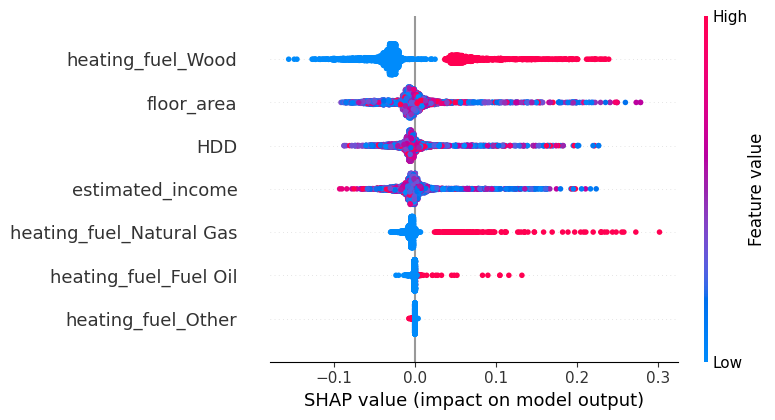

In [34]:
import shap
# Create SHAP Tree Explainer
explainer = shap.TreeExplainer(model)

# Get SHAP values for class 1 (electrification candidates)
shap_values = explainer.shap_values(X_test)

# Get SHAP values for class 1 (label = 1)
shap_values_class1 = shap_values[:, :, 1]
shap.summary_plot(shap_values_class1, X_test)

In [55]:
pip install streamlit


  Using cached streamlit-1.44.1-py3-none-any.whl.metadata (8.9 kB)
  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached protobuf-5.29.4-cp38-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached GitPython-3.1.44-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached narwhals-1.33.0-py3-none-any.whl.metadata (9.2 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
Using cached streamlit-1.44.1-py3-none-any.whl (9.8 MB)
Using cached altair-5.5.0-py3-none-any.whl (731 kB)
Using cached blinker-1.9.0

In [56]:
!pip install --upgrade pip setuptools wheel
!pip install pyarrow

In [53]:
import pickle

# Save your trained model
with open("electrification_model.pkl", "wb") as f:
    pickle.dump(model, f)
feature_columns = X_train.columns.tolist()
with open("model_columns.pkl", "wb") as f:
    pickle.dump(feature_columns, f)
